In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score


In [3]:
df = pd.read_csv('../data/processed/new_features_news_1.csv')
df.head()

,title,text,date,label,title_length,text_length,year,month,day,weekday,exclamation_count,avg_text_sent_length,avg_title_sent_length,title_verb_count,title_adj_count
0,Many 'lost' voters say they have found their c...,WASHINGTON/NEW YORK (Reuters) - Ted Wade hasn’...,2016-01-17,0,63,6517,2016.0,1.0,17.0,6.0,0,22.620000,11.0,3,1
1,"Iranian Revolutionary Guards commander, anothe...",BEIRUT (Reuters) - A commander in Iran s elite...,2017-11-19,0,87,2435,2017.0,11.0,19.0,6.0,0,25.062500,11.0,1,1
2,Cambodian leader gets China's backing as West ...,PHNOM PENH (Reuters) - Cambodian Prime Ministe...,2017-09-04,0,64,3431,2017.0,9.0,4.0,0.0,0,26.608696,10.0,2,1
3,Ex-KKK Grand Wizard: Maine Gov. Right To Call...,David Duke is perhaps one of the most notoriou...,2016-01-11,1,90,2419,2016.0,1.0,11.0,0.0,0,17.520000,18.0,1,0
4,FINGER-WAGGING GRANNY HILLARY CLINTON Blows Up...,Hillary Clinton shows her true colors here wit...,2016-03-31,1,91,95,2016.0,3.0,31.0,3.0,0,16.000000,7.0,1,0


# Data

In [4]:
print(f"Przed usunieciem: {df.shape}")
df = df[~df['year'].isin([2015,2018])]
print(f"Po usunieciu: {df.shape}")

Przed usunieciem: (39105, 15)
Po usunieciu: (37425, 15)


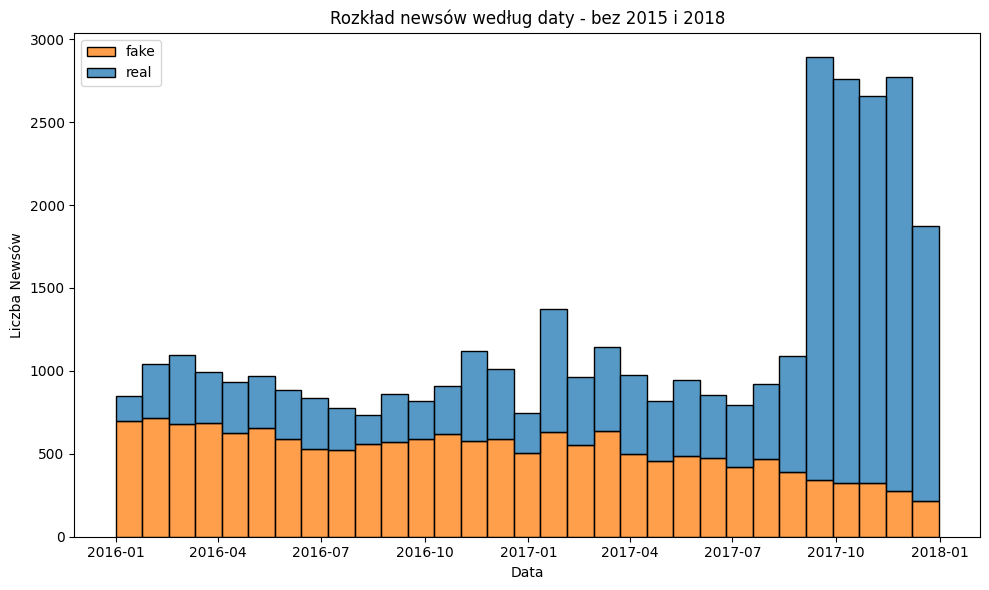

In [5]:
df['date'] = pd.to_datetime(df['date'],errors="coerce")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='date', hue='label', kde=False,multiple='stack', color='salmon')

plt.title('Rozkład newsów według daty - bez 2015 i 2018')
plt.xlabel('Data')
plt.ylabel('Liczba Newsów')
plt.legend(['fake','real'])
plt.tight_layout()
plt.show() 

In [6]:
df[df['date'].isna()]

,title,text,date,label,title_length,text_length,year,month,day,weekday,exclamation_count,avg_text_sent_length,avg_title_sent_length,title_verb_count,title_adj_count
5726,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,NaT,1,66,66,NaN,NaN,NaN,NaN,0,1.000000,1.0,0,0
6172,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,NaT,1,145,145,NaN,NaN,NaN,NaN,0,1.000000,1.0,0,0
9593,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,NaT,1,149,149,NaN,NaN,NaN,NaN,0,1.000000,1.0,0,0
12985,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,NaT,1,74,74,NaN,NaN,NaN,NaN,0,1.000000,1.0,0,0
22343,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,NaT,1,8,578,NaN,NaN,NaN,NaN,1,5.083333,1.0,0,0
37412,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,NaT,1,88,88,NaN,NaN,NaN,NaN,0,1.000000,1.0,0,1


In [7]:
df = df[~df['date'].isna()]

In [8]:
def half_year(x):
    if x['month'] <= 6:
        return f'H1_{x["year"]}'
    else:
        return f'H2_{x["year"]}'  

df['half_year'] = df.apply(half_year, axis=1)
df.head()


,title,text,date,label,title_length,text_length,year,month,day,weekday,exclamation_count,avg_text_sent_length,avg_title_sent_length,title_verb_count,title_adj_count,half_year
0,Many 'lost' voters say they have found their c...,WASHINGTON/NEW YORK (Reuters) - Ted Wade hasn’...,2016-01-17,0,63,6517,2016.0,1.0,17.0,6.0,0,22.620000,11.0,3,1,H1_2016.0
1,"Iranian Revolutionary Guards commander, anothe...",BEIRUT (Reuters) - A commander in Iran s elite...,2017-11-19,0,87,2435,2017.0,11.0,19.0,6.0,0,25.062500,11.0,1,1,H2_2017.0
2,Cambodian leader gets China's backing as West ...,PHNOM PENH (Reuters) - Cambodian Prime Ministe...,2017-09-04,0,64,3431,2017.0,9.0,4.0,0.0,0,26.608696,10.0,2,1,H2_2017.0
3,Ex-KKK Grand Wizard: Maine Gov. Right To Call...,David Duke is perhaps one of the most notoriou...,2016-01-11,1,90,2419,2016.0,1.0,11.0,0.0,0,17.520000,18.0,1,0,H1_2016.0
4,FINGER-WAGGING GRANNY HILLARY CLINTON Blows Up...,Hillary Clinton shows her true colors here wit...,2016-03-31,1,91,95,2016.0,3.0,31.0,3.0,0,16.000000,7.0,1,0,H1_2016.0


In [9]:
df = df.drop(['date','day','year','month'],axis=1) 
df.head()

,title,text,label,title_length,text_length,weekday,exclamation_count,avg_text_sent_length,avg_title_sent_length,title_verb_count,title_adj_count,half_year
0,Many 'lost' voters say they have found their c...,WASHINGTON/NEW YORK (Reuters) - Ted Wade hasn’...,0,63,6517,6.0,0,22.620000,11.0,3,1,H1_2016.0
1,"Iranian Revolutionary Guards commander, anothe...",BEIRUT (Reuters) - A commander in Iran s elite...,0,87,2435,6.0,0,25.062500,11.0,1,1,H2_2017.0
2,Cambodian leader gets China's backing as West ...,PHNOM PENH (Reuters) - Cambodian Prime Ministe...,0,64,3431,0.0,0,26.608696,10.0,2,1,H2_2017.0
3,Ex-KKK Grand Wizard: Maine Gov. Right To Call...,David Duke is perhaps one of the most notoriou...,1,90,2419,0.0,0,17.520000,18.0,1,0,H1_2016.0
4,FINGER-WAGGING GRANNY HILLARY CLINTON Blows Up...,Hillary Clinton shows her true colors here wit...,1,91,95,3.0,0,16.000000,7.0,1,0,H1_2016.0


In [10]:
df[['half_year','label']].groupby(by='half_year').mean()

,label
half_year,
H1_2016.0,0.680326
H1_2017.0,0.533394
H2_2016.0,0.654113
H2_2017.0,0.170910


In [11]:
df = df.drop(['text_length','title_verb_count','title_adj_count'],axis = 1)
df.head()

,title,text,label,title_length,weekday,exclamation_count,avg_text_sent_length,avg_title_sent_length,half_year
0,Many 'lost' voters say they have found their c...,WASHINGTON/NEW YORK (Reuters) - Ted Wade hasn’...,0,63,6.0,0,22.620000,11.0,H1_2016.0
1,"Iranian Revolutionary Guards commander, anothe...",BEIRUT (Reuters) - A commander in Iran s elite...,0,87,6.0,0,25.062500,11.0,H2_2017.0
2,Cambodian leader gets China's backing as West ...,PHNOM PENH (Reuters) - Cambodian Prime Ministe...,0,64,0.0,0,26.608696,10.0,H2_2017.0
3,Ex-KKK Grand Wizard: Maine Gov. Right To Call...,David Duke is perhaps one of the most notoriou...,1,90,0.0,0,17.520000,18.0,H1_2016.0
4,FINGER-WAGGING GRANNY HILLARY CLINTON Blows Up...,Hillary Clinton shows her true colors here wit...,1,91,3.0,0,16.000000,7.0,H1_2016.0


# Preprocessing

In [12]:
df.describe()

,label,title_length,weekday,exclamation_count,avg_text_sent_length,avg_title_sent_length
count,37419.000000,37419.000000,37419.000000,37419.000000,37419.000000,37419.000000
mean,0.433523,75.978380,2.695796,0.411395,23.955010,10.943237
std,0.495568,21.600662,1.840653,1.471930,6.501278,3.600871
min,0.000000,18.000000,0.000000,0.000000,1.000000,2.000000
25%,0.000000,62.000000,1.000000,0.000000,20.375000,9.000000
50%,0.000000,71.000000,3.000000,0.000000,23.935484,10.000000
75%,1.000000,86.000000,4.000000,0.000000,27.357143,13.000000
max,1.000000,279.000000,6.000000,133.000000,144.000000,44.000000


In [13]:
num_features = ['title_length', 'avg_text_sent_length', 'avg_title_sent_length', 'exclamation_count']
num_transformer = StandardScaler()

cat_features = ['weekday', 'half_year']
cat_transformer = OneHotEncoder(sparse_output=False)

text_transformer_title = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=500, stop_words='english'))
])

text_transformer_text = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=500, stop_words='english'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
        ('title_tfidf', text_transformer_title, 'title'),
        ('text_tfidf', text_transformer_text, 'text'),
    ]
)
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f'Wymiary danych po przekształceniu (treningowe): {X_train_processed.shape}')
print(f'Wymiary danych po przekształceniu (testowe): {X_test_processed.shape}')

Wymiary danych po przekształceniu (treningowe): (29935, 1015)
Wymiary danych po przekształceniu (testowe): (7484, 1015)


# Model Training

In [14]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_processed, y_train)

y_pred = model.predict(X_test_processed)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")


Confusion Matrix:
[[4231   17]
 [  49 3187]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4248
           1       0.99      0.98      0.99      3236

    accuracy                           0.99      7484
   macro avg       0.99      0.99      0.99      7484
weighted avg       0.99      0.99      0.99      7484


Accuracy: 0.9912


In [ ]:
sample = pd.DataFrame([{
    'title': "BREAKING  : Scientists Prove that Drinking 3 Cups of Coffee a Day Can Reverse Aging and Make You Immortal!! WATCH VIDEO!",
    'text': "In a shocking new study, scientists have uncovered the secret to eternal youth! According to the latest research conducted by top experts at a prestigious university, drinking exactly three cups of coffee per day can not only reverse the signs of aging but may also increase your lifespan indefinitely. The study, which followed over 10,000 participants for more than a decade, found that coffee contains special compounds that regenerate cells and repair DNA damage. Health authorities are in denial, calling the study ‘unscientific,’ but countless online testimonials from coffee lovers around the world claim to have experienced miraculous health benefits. Experts are calling it the most important discovery of the century – the key to immortality. Share this with everyone you know before they censor it!",
    'title_length': 23,
    'avg_text_sent_length': 15,
    'avg_title_sent_length': 20,
    'exclamation_count': 4,
    'weekday': 3,
    'half_year': 'H1_2017.0'
}])

sample = preprocessor.transform(sample)

prediction = model.predict(sample)
proba = model.predict_proba(sample)

print(f"Predykcja (etykieta): {prediction[0]}")
print(f"Prawdopodobieństwo klas: {proba[0]}")

Predykcja (etykieta): 1
Prawdopodobieństwo klas: [0.06669017 0.93330983]
